In [1]:
import pandas as pd
import numpy as np
import os

import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

In [2]:
fconfig = open('config_agn_sdss_var.json')
config_var = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_color.json')
config_color = Config(fconfig)
fconfig.close()
del fconfig

fconfig = open('config_agn_sdss_var&color.json')
config_var_color = Config(fconfig)
fconfig.close()
del fconfig

In [3]:
from data_process import data_preparation

def select_data(config):
    #data = pd.DataFrame()
    #data preparation
    if(not config.flags['data_preprocessing']['work']):
        if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
            data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
        else:
            data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
    
    return data

In [5]:
from network import NN
from data_process import data_preparation, get_features

#network training
def network(data,config):
    #features from config
    #name from config
    print('Sample name: ', config.name_sample)
    print('Features: ', config.features["data"])
    
    #hyperparams from config
    batch_size = config.hyperparam['batch_size']
    num_ep = config.hyperparam['num_ep']
    optimizer = config.hyperparam['optimizer']
    loss = config.hyperparam['loss']
    validation_split = config.hyperparam['validation_split']
    
    #balanced class
    class_weights = None
    if(config.hyperparam["model_variable"]["balanced"]):
        from sklearn.utils import class_weight
        y = np.zeros(data.shape[0])
        cl = np.array(data[config.name_class_cls].values)
        #print(cl)
        for i in range(data.shape[0]):
            y[i] = np.argmax(cl[i,:])
        class_weights = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(y),y = y)))
        print("class weights",class_weights)
        del y, cl

    print(data)

    print("Features mode list:\t",config.features["train"])
    features = get_features(config.features["train"],config)
    print("Features train values:\t",features)
    
    #sample_weight
    sample_weight = None
    if(config.hyperparam["model_variable"]["sample_weight"] in config.flags['data_preprocessing']['main_sample']['weight']['method']):
        #sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values
        sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values.T[0]
        print(sample_weight)

    try:
        data[features]
    except:
        raise Exception("data don't have initiated features, check config.features['train'] value and WARNINGs above")

    if(config.hyperparam["model_variable"]["work"]):
        NN(data[features],data[config.name_class_cls],data['z'],sample_weight,validation_split,batch_size,num_ep,optimizer,loss,class_weights,
        output_path_predict = config.path_predict,
        output_path_mod = config.path_model,
        output_path_weight = config.path_weight,
        path_save_eval = config.path_eval,
        config=config)

2024-05-03 05:43:19.349281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
data = select_data(config_var)

data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,239.177460,27.055966,0.090353,0.000027,0.086462,0.171325,0.000000,1.000000,0.000000,12,...,2.357481,0.340302,0.687168,0.787404,0,0,0,0,1,0
1,169.268150,4.427474,1.170077,0.000150,0.032336,0.068488,1.000000,0.000000,0.000000,12,...,0.837587,0.263093,0.681880,0.827843,1,0,0,0,0,0
2,43.250305,-3.342976,0.244153,0.000030,0.200110,0.594563,0.000336,0.013068,0.984260,13,...,1.140024,0.338401,0.654243,0.815071,0,0,0,0,1,0
3,172.780700,45.426833,1.229971,0.000552,0.045566,0.092679,0.999922,0.000000,0.000078,12,...,1.358093,0.379193,0.672553,0.808466,1,0,0,0,0,0
4,150.185940,2.474568,0.000868,0.000008,0.124031,0.150412,0.000000,0.000000,0.999934,12,...,0.739153,0.254910,0.702885,0.882802,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090354,219.531190,15.218142,0.098927,0.000009,0.011590,0.030389,0.000000,1.000000,0.000000,13,...,2.128290,0.438617,0.677479,0.554826,0,0,0,1,0,0
1090355,9.150885,23.917155,2.520883,0.000440,0.045041,0.395291,1.000000,0.000000,0.000000,13,...,3.519597,0.078064,0.642015,0.640678,1,0,0,0,0,0
1090356,33.514822,6.673856,-0.000333,0.000012,0.065429,0.236262,0.000000,0.000000,0.999985,13,...,3.740190,0.071538,0.565084,0.879244,0,0,0,0,0,1
1090357,3.715578,4.087570,1.855977,0.000165,0.068224,0.877788,1.000000,0.000000,0.000000,13,...,1.609952,0.407870,0.639610,0.800421,1,0,0,0,0,0


In [51]:
network(data,config_var)
network(data,config_color)
network(data,config_var_color)

Sample name:  sdss_diploma_sample_dereddedcut_rangecut_flux_color_mcdcut_cbalancedfalse_wbalanced_e200_v02_arelu_erecall_ldropout_var
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.5069758293997523, 1: 11.318292227204783, 2: 8.05632397925256, 3: 2.162741294361269, 4: 0.48256051706374076, 5: 0.7810146982980918}
                 RA        DEC         z     z_err   angDist  angDist.1   
0        239.177460  27.055966  0.090353  0.000027  0.086462   0.171325  \
1        169.268150   4.427474  1.170077  0.000150  0.032336   0.068488   
2         43.250305  -3.342976  0.244153  0.000030  0.200110   0.594563   
3        172.780700  45.426833  1.229971  0.000552  0.045566   0.092679   
4        1

In [85]:
from statistic import metric_sklearn, metric_, main_metrics, kfold_metrics

2024-05-09 08:29:42.244788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [94]:
def picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config):
    from matplotlib import pyplot as plt
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    def pic(axs,i,j,l,one_ml_cycle_main,one_ml_cycle_all_kfold):

        axs[i,j].scatter(index_mass,one_ml_cycle_main.loc[index[i*3+j],:],lw=5, label=f"main_{picture_label[l]}", color = colors[l])
        axs[i,j].plot(index_mass,one_ml_cycle_main.loc[index[i*3+j],:],lw=2, color = colors[l])
        #axs[i,j].plot(index_mass,one_ml_cycle_all_kfold.loc[idx[index[i*3+j],'mean'],:], lw=5)
        axs[i,j].errorbar(index_mass,one_ml_cycle_all_kfold.loc[idx[index[i*3+j],'mean'],:],
                        yerr=[one_ml_cycle_all_kfold.loc[idx[index[i*3+j],'mean'],:].values - one_ml_cycle_all_kfold.loc[idx[index[i*3+j],'min'],:].values,
                                one_ml_cycle_all_kfold.loc[idx[index[i*3+j],'max'],:].values - one_ml_cycle_all_kfold.loc[idx[index[i*3+j],'mean'],:].values], 
                        fmt='o', markersize=10, elinewidth=3, capsize=20, capthick=3, label=f"kfold_{picture_label[l]}", color = colors[l])

    index = ['precision','recall','f1','bacc','k','mcc','roc']
    idx = pd.IndexSlice

    fig=plt.figure()
    fig, axs = plt.subplots(2,3)

    index_mass = [config.name_class[i] for i in range(6)]
    for i in range(2):
        for j in range(3):
            #
            for l in range(len(one_ml_cycle_main_mass)):
                pic(axs,i,j,l,one_ml_cycle_main_mass[l],one_ml_cycle_all_kfold_mass[l])
            #
            axs[i,j].tick_params(axis='x', labelsize=30)
            axs[i,j].tick_params(axis='y', labelsize=30)
            axs[i,j].set_xlabel(index[i*3+j],fontsize=40)
            axs[i,j].legend(prop={'size': 15})
            axs[i,j].set_ylim([0.1,1.1])

    fig.set_size_inches(30,20)
    plt.show()

In [86]:
one_ml_cycle_all_kfold_var_1 = kfold_metrics(True,config_var)
one_ml_cycle_all_kfold_color_1 = kfold_metrics(True,config_color)
one_ml_cycle_all_kfold_var_color_1 = kfold_metrics(True,config_var_color)

In [87]:
%%time
one_ml_cycle_all_kfold_var = kfold_metrics(False,config_var)
one_ml_cycle_all_kfold_color = kfold_metrics(False,config_color)
one_ml_cycle_all_kfold_var_color = kfold_metrics(False,config_var_color)

CPU times: user 19.7 s, sys: 55.2 ms, total: 19.7 s
Wall time: 19.7 s


In [96]:
%%time
one_ml_cycle_main_var_1, one_ml_cycle_main_metr_var_1 = main_metrics(True,config_var)
one_ml_cycle_main_color_1, one_ml_cycle_main_metr_color_1 = main_metrics(True,config_color)
one_ml_cycle_main_var_color_1, one_ml_cycle_main_metr_var_color_1 = main_metrics(True,config_var_color)

CPU times: user 2min 24s, sys: 902 ms, total: 2min 25s
Wall time: 2min 25s


In [89]:
one_ml_cycle_main_var, one_ml_cycle_main_metr_var = main_metrics(False,config_var)
one_ml_cycle_main_color, one_ml_cycle_main_metr_color = main_metrics(False,config_color)
one_ml_cycle_main_var_color, one_ml_cycle_main_metr_var_color = main_metrics(False,config_var_color)

In [90]:
one_ml_cycle_main_mass = [one_ml_cycle_main_var,one_ml_cycle_main_color,one_ml_cycle_main_var_color,one_ml_cycle_main_var_1,one_ml_cycle_main_color_1,one_ml_cycle_main_var_color_1]
one_ml_cycle_all_kfold_mass = [one_ml_cycle_all_kfold_var,one_ml_cycle_all_kfold_color,one_ml_cycle_all_kfold_var_color,one_ml_cycle_all_kfold_var_1,one_ml_cycle_all_kfold_color_1,one_ml_cycle_all_kfold_var_color_1]
picture_label = ["var","color","var_color","var_1","color_1","var_color_1"]

<h2> <i>"_1"</i> mark <b>e200+outlire</b> usage</h2>

<Figure size 640x480 with 0 Axes>

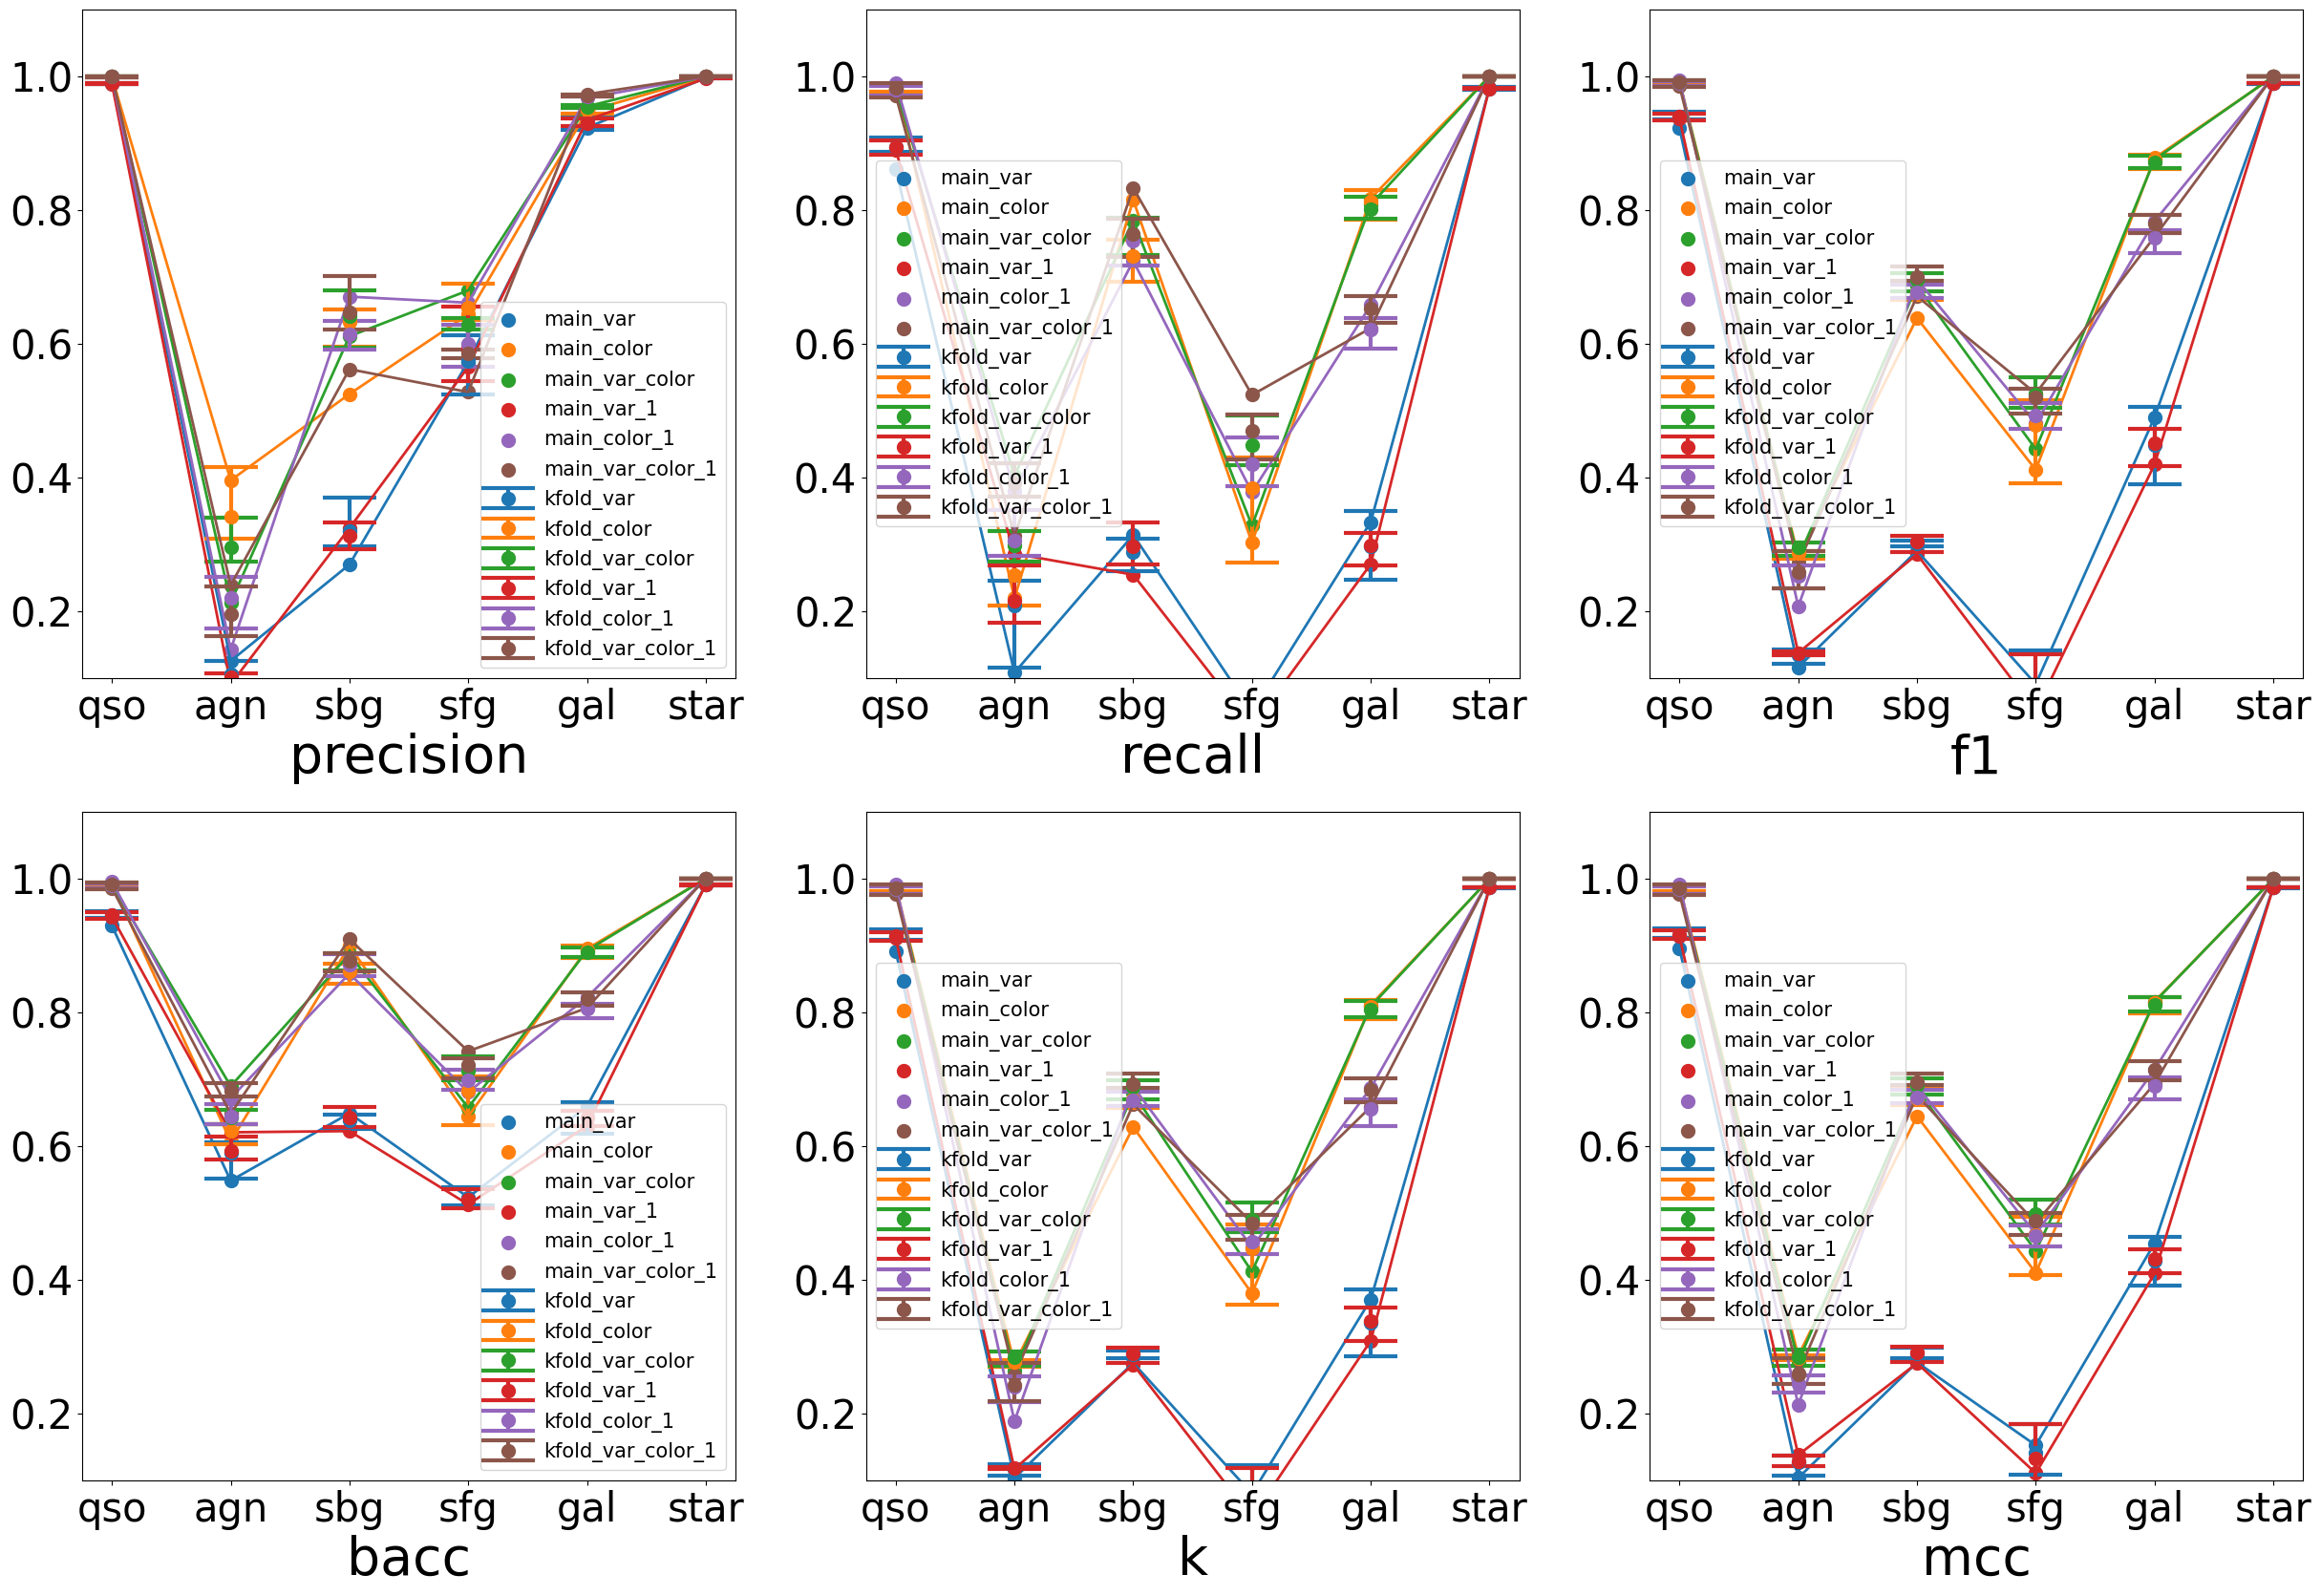

In [61]:
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_var)

<h2> <i>"_1"</i> mark <b>argmax</b> usage</h2>

<Figure size 640x480 with 0 Axes>

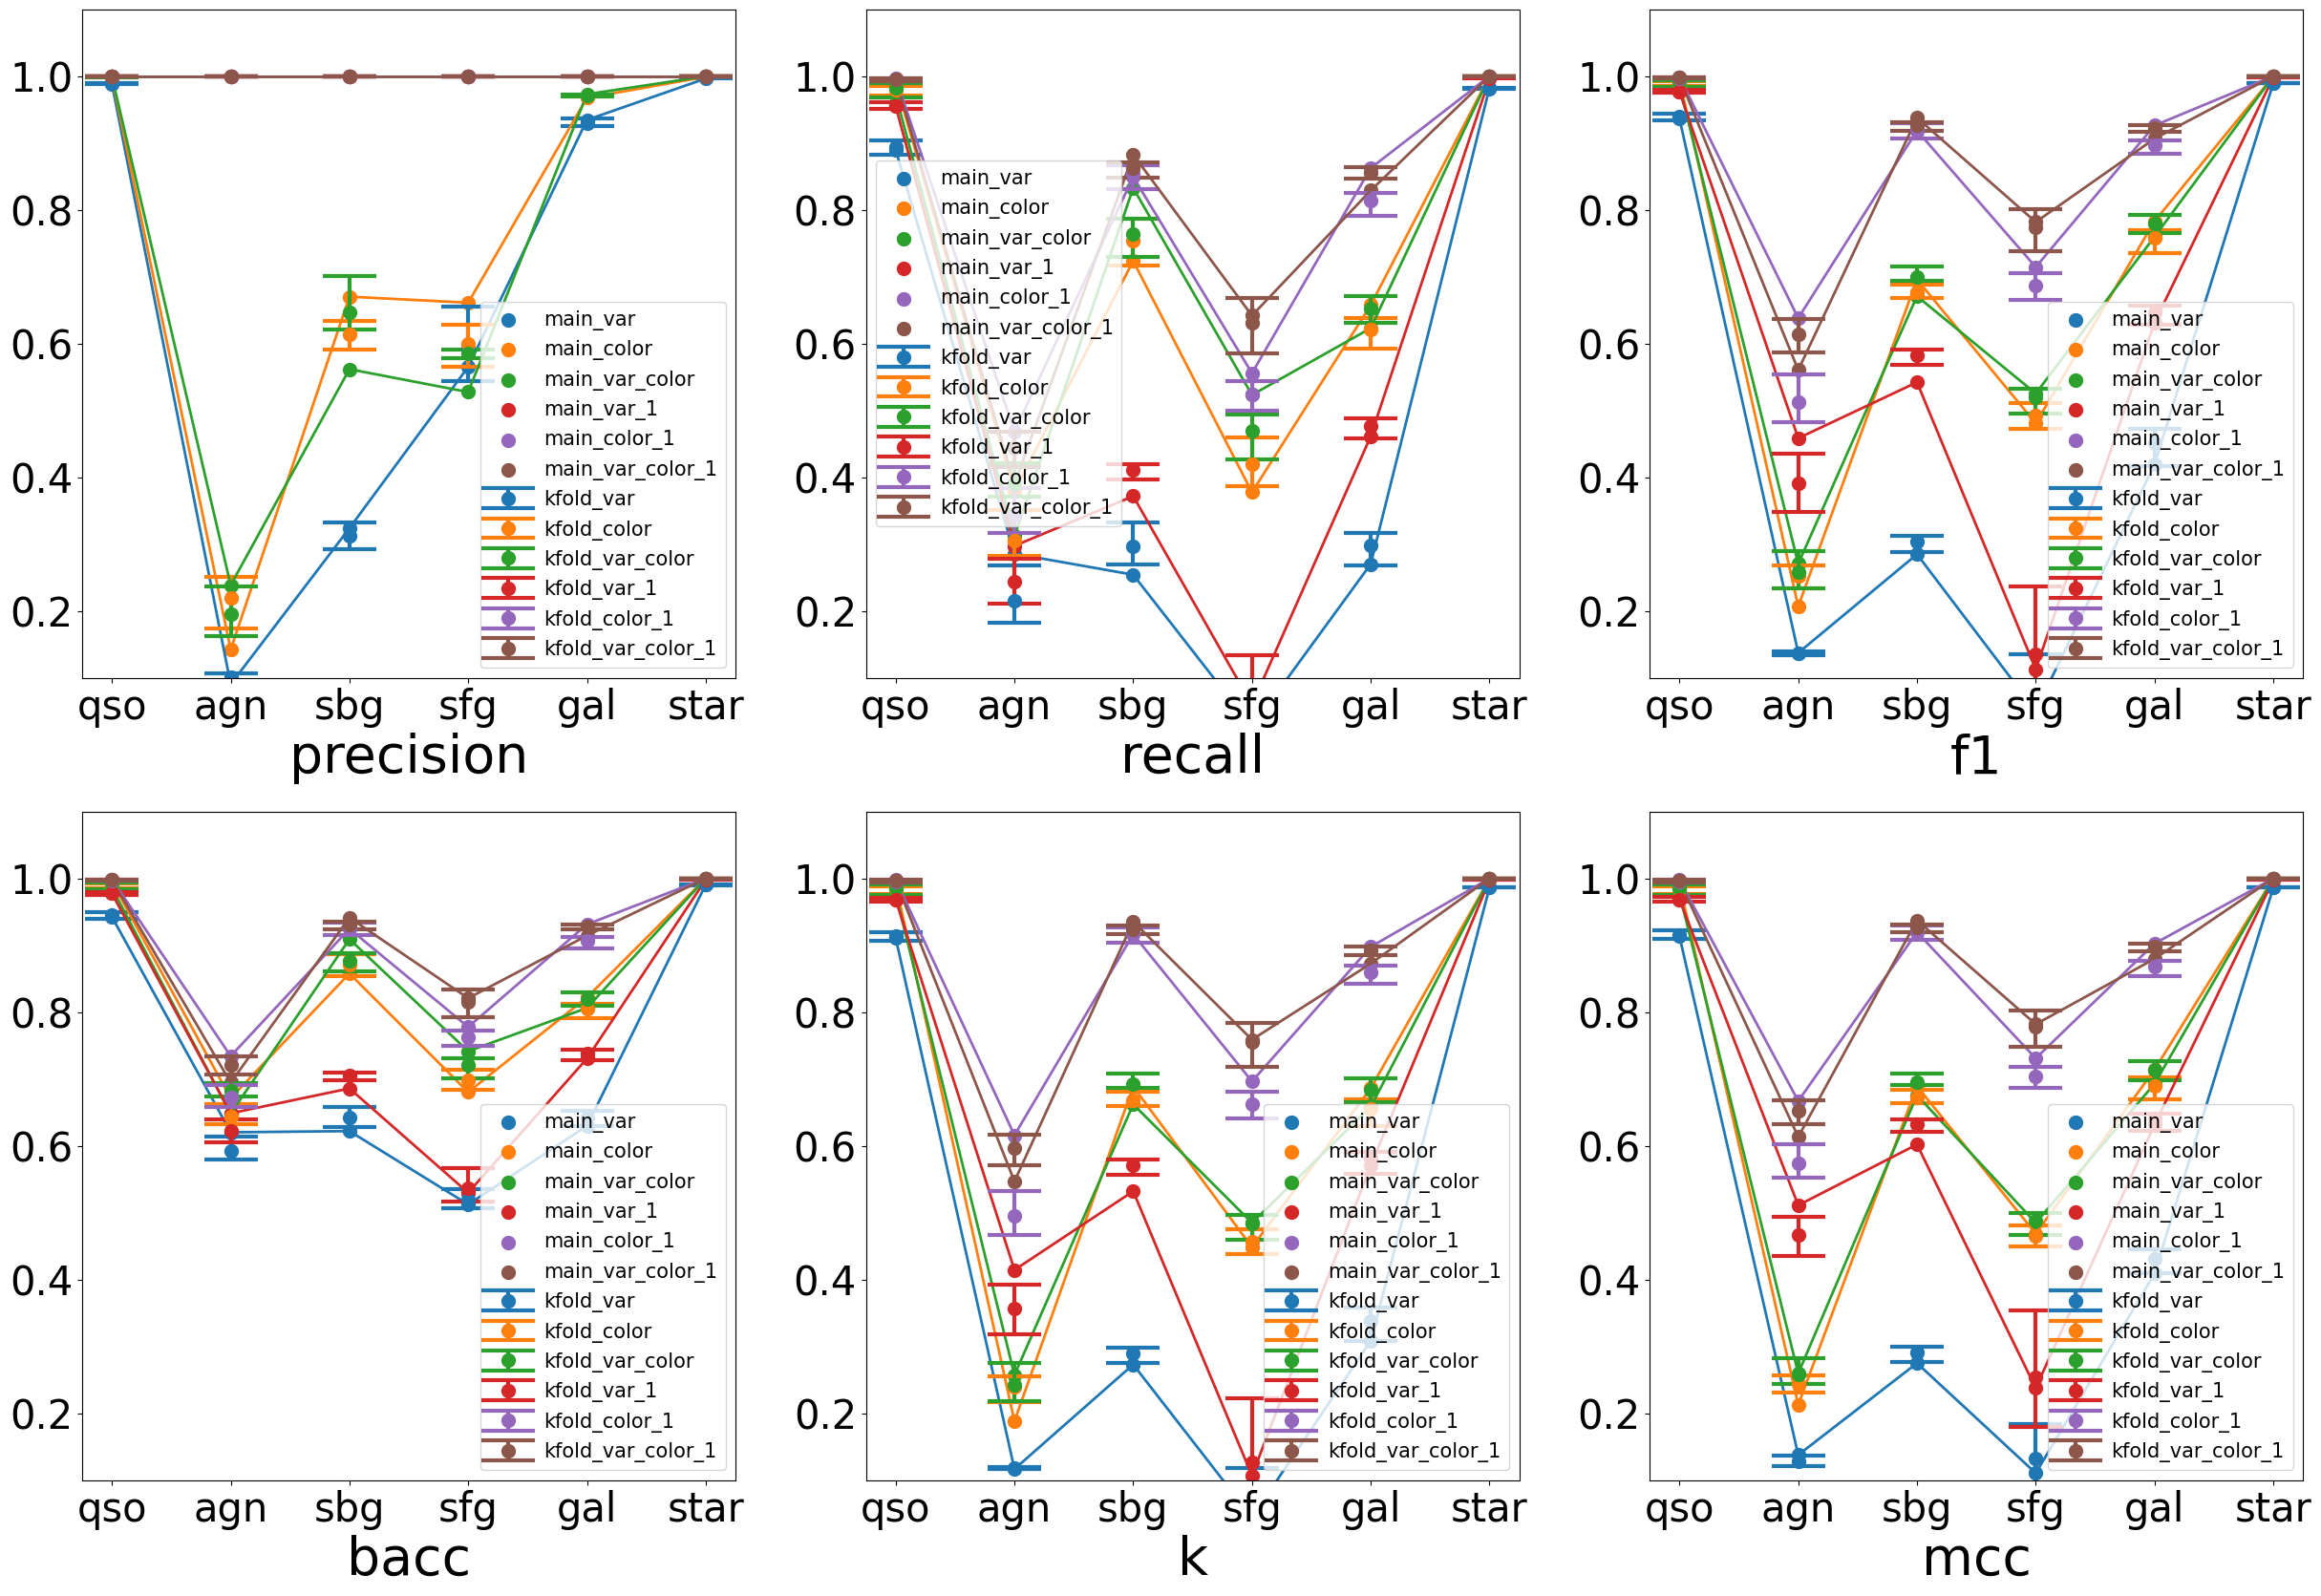

In [95]:
picture_metrics(one_ml_cycle_main_mass,one_ml_cycle_all_kfold_mass,picture_label,config_color)